> python3 $SUMO_HOME/tools/visualization/plot_summary.py -i basic_output.xml --xlim 0,1000 -o summary_basic.png -m stopped


# Simulation setup

In [15]:
import os, sys
import numpy as np
import traci

In [3]:
gui = True #to run either sumo or sumo-gui
SUMO_HOME = os.environ["SUMO_HOME"] #locating the simulator
default_scenario = "./basic_simulation.sumocfg"

sys.path.append(SUMO_HOME+"/tools")
import sumolib

In [7]:
def run_simulation(gui_needed: bool, scenario: str):
    '''Runs a SUMO simulation.
        -----------------------
        parameters:
        - gui-needed: if true SUMO is started with GUI
        - scenario: path to the .sumocfg file to run'''
    
    sumo_binary = "sumo-gui" if gui_needed else "sumo"
    sumo_cmd = [sumo_binary, "-c", scenario]
    #starting SUMO server:
    traci.start(sumo_cmd)
    
    #conducting the simulation:
    step = 0
    while step < 600:
        step += 1
        traci.simulationStep()
    
    traci.close()

In [8]:
run_simulation(True, default_scenario)

 Retrying in 1 seconds


# Parsing and plotting outputs

In [9]:
output_file = "outputs/basic_output.xml"

In [10]:
def get_stopped_vehicles_from_output(output_file: str):
    '''Extracts number of stopped vehicles from a simulation summary output.
        ------------------------
        parameters:
        - output_file: the simulation output to parse
        
        Returns: time and #stopped vehicle pairs'''
    
    t, v = [], [] #(time x value) pairs
    for time, val in sumolib.xml.parse_fast(output_file, "step", ("time", "stopped")):
        t.append(sumolib.miscutils.parseTime(time))
        v.append(float(val))
    return t,v

In [11]:
import matplotlib.pyplot as plt

def plot_stopped_vehicles(time_values, stopped_values, titles):
    fig, ax = plt.subplots()
    for i in range(len(time_values)):
        ax.plot(time_values[i], stopped_values[i], label=titles[i])
    ax.set_xlabel("timestep")
    ax.set_ylabel("#stopped vehicles")
    ax.set_title("Number of stopped vehicles")
    ax.legend()
    return fig, ax

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Number of stopped vehicles'}, xlabel='timestep', ylabel='#stopped vehicles'>)

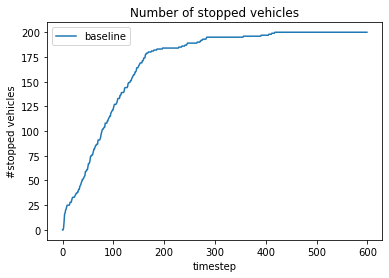

In [12]:
t,v = get_stopped_vehicles_from_output(output_file)
plot_stopped_vehicles([t], [v], ["baseline"])

# Processing routes

We have to collect the routes that the vehicles actually use during the original simulation.

In [ ]:
def read_movements(filename: str) -> list:
    '''Reads the given route file and returns the edges of the routes'''
    
    movements = []
    
    for vehicle in sumolib.xml.parse(filename, "vehicle"):
        route = vehicle.route[0] # access the first (and only) child element with name 'route'
        edges = route.edges.split()
        i = 0
        mov_ = []
        parking = vehicle.stop[0].parkingArea.split("pl")[-1]
        while i<len(edges) and edges[i] != parking:
            mov_.append(edges[i])
            i += 1
        movements.append(mov_)
        
    return movements

In [4]:
movements = read_movements("scenario/parking_routes.rou.xml")

# Instructed simulation

We have to achieve the following via TraCI:
1. make vehicles complete their routes (collected previously), controlled by the rerouter device
2. then go to a parking lot

In [6]:
traci.start(["sumo-gui", "-c", "auction_simulation.sumocfg"])

traci.route.add("route0", movements[0])
vehicle = traci.vehicle.add("veh0", "route0", typeID="reroutingType")

step = 0
while step < 500:
    step += 1
    traci.simulationStep()
    #if traci.vehicle.isStopped("veh0"):
    try:
        route_idx = traci.vehicle.getRouteIndex("veh0")
        route = traci.vehicle.getRoute("veh0")
        if route_idx == len(route)-1:
            #traci.vehicle.setR
            #traci.route.add("route_to_pl344_0", edges=["344"])
            #traci.vehicle.add
            traci.vehicle.changeTarget("veh0", "344")
            traci.vehicle.setParkingAreaStop("veh0", "pl344", duration=86400)
            #traci.vehicle.rerouteParkingArea("veh0", "pl344", duration=86400)
    except:
        pass
        #traci.vehicle.setParkingAreaStop("veh0", "pl344", duration=86400)

traci.close()

 Retrying in 1 seconds


# Connecting to the Auction method

In [16]:
def get_distance_to_parkings(traci, vehicle_id: str, sumo_parkings_lane_id: list) -> np.array:
    '''Collecting distances of parking lots for each vehicles'''
    distances = []
    last_position = traci.vehicle.getRoute(vehicle_id)[-1]
    for p in sumo_parkings_lane_id:
        distances.append(traci.simulation.getDistanceRoad(last_position, 0, p, 0))
    return np.array(distances)

### Reading parking lot capacities:

In [18]:
import xml.etree.ElementTree as ET

def read_pl_capacities(filename: str) -> (list,list):
    '''Reads an additional file that contains parking lot definitions. Returns the parking lot ids and the corresp. capacities'''
    tree = ET.parse('scenario/parkings.add.xml')
    root = tree.getroot()
    p_ids = []
    p_capacities = []
    for parea in root:
        p_ids.append(parea.attrib["id"])
        p_capacities.append(parea.attrib["roadsideCapacity"])
    return p_ids, p_capacities

In [ ]:
import auction

def init_auction_method(parking_capacities, vehicle_numbers, starting_prices, preference_function, bid_step = 10, max_price = 5000)-> list, list:
    """Initializes the participants of the auction method
       -------------
       parameters:
           - parking_capacities: capacity values of the parking lots (number of auctions),
           - vehicle_numbers: number of vehicles (number of buyers),
           - starting_prices: list of starting prices of the auctions,
           - preference_function: the function that calculates which parking lot is preferred.
                                   signature: preference_function(buyer_object, current_price_list),
           - bid_step: amount of money by which current bids will be increased during auctions,
           - max_price: maximum price that the buyers are willing to accept"""
    
    auctions = []
    buyers = []
    
    for pcap in parking_capacities:
        for i in range(pcap):
            auctions.append(auction.Auctioneer(starting_prices[len(auctions)], bid_step))
            
    buyers = [auction.Buyer(auctions, max_price, preference_function) for i in range(vehicle_numbers)]
    return auctions, buyers

In [19]:
def min_price(buyer, bids):
    return np.argmin(bids)

class min_distance_preference:
    def __init__(self, distance_mtx, buyers):
        self.distance_mtx = distance_mtx
        self.buyers = buyers
        
    def __call__(self, buyer, bids):
        np.argmin(self.distance_mtx[self.buyers.index(buyer)])
        
class min_distance_preference:
    def __init__(self, distance_mtx, buyers):
        self.distance_mtx = distance_mtx
        self.buyers = buyers
        
    def __call__(self, buyer, bids):
        np.argmin(bids + 2*self.distance_mtx[self.buyers.index(buyer)])

In [20]:
def init_simulation(traci_commands: list, movements: list, parking_lot_file: str):
    '''Initializes the simulation, and returns the final distances
       ----------------
       parameters:
        - traci_commands: commands to start TraCI with,
        - movements: list of the edges simulated vehicles shall go through,
        - parking_lot_file: path to the file defining parkingAreas
        
       returns:
        the distances to parking lots when the vehicles are finished their routes'''
    traci.start(traci_commands)
    
    for i in range(len(movements)):
        traci.route.add("route%d" % i, movements[i])
        vehicle = traci.vehicle.add("veh%d" % i, "route%d" % i, typeID="reroutingType")
        
    traci.simulationStep()
    
    p_ids, p_caps = read_pl_capacities(parking_lot_file)
    distances = []
    for i in range(len(movements)):
        distances.append(get_distance_to_parkings(traci, "veh%d" % i, p_ids.split("pl")[-1]))
    
    return distances

In [ ]:
def simulate_after_auction(traci, parking_mapping, max_step = 600):
    veh_list = traci.vehicle.getIDList()
    
    step = 1
    while step < max_step:
        step += 1
        traci.simulationStep()
        for veh in veh_list:
            try:
                route_idx = traci.vehicle.getRouteIndex(veh)
                route = traci.vehicle.getRoute(veh)
                if route_idx == len(route)-1:
                    traci.vehicle.changeTarget(veh, parking_mapping[veh].split("pl")[-1])
                    traci.vehicle.setParkingAreaStop(veh, parking_mapping[veh], duration=86400)
            except:
                pass

In [ ]:
#TODO: init sim. -> auction -> create mapping -> simulation -> evaluate results 